In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv("data.csv", parse_dates=True, index_col = "Dates",sep=';')
print(f"Nombre d'échantillons : {len(df)}")
df

Nombre d'échantillons : 6357


,EONIA Index,SXXR Index
Dates,,
1999-01-04,3.200,358.62
1999-01-05,3.200,363.10
1999-01-06,3.210,371.46
1999-01-07,3.210,367.03
1999-01-08,3.210,368.87
...,...,...
2023-05-10,3.145,1086.08
2023-05-11,3.145,1086.85
2023-05-12,3.148,1091.72


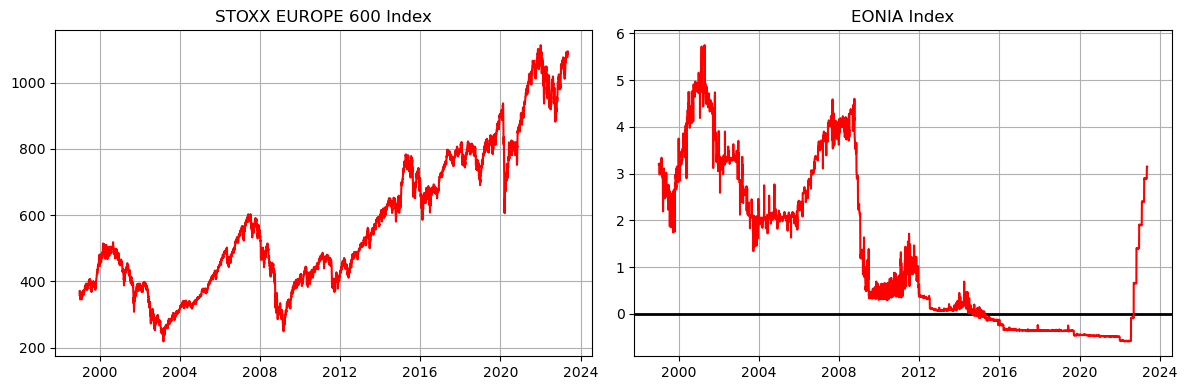

In [4]:
sxxr = pd.DataFrame(df["SXXR Index"])
eonia = pd.DataFrame(df["EONIA Index"])

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr, c="r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(eonia,c="r")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
def interest(df:pd.DataFrame=sxxr, initial:float = 100,year:int = 2000, horizon:int=5, y0:int = 2000,alldata:bool = True)->pd.DataFrame:
    """
    parameters:
        df:The index SXXR
        initial: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """
    tabn = df[str(y0-1):str(y0-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    
    tab = df[str(y0):str(y0+horizon)]
    tab = pd.concat([tabn,tab])
    
    n = len(tab)
    S = [x for x in tab["SXXR Index"]]
    rate = []
    S0 = S[0]
    compteur = 0
    for t in S:
        if compteur==0:
            rendement = round((S[compteur]/S0 -1)*100,3)
        else:
            rendement = round((S[compteur]/S[compteur-1] -1)*100,3)
        rate.append(rendement)
        compteur += 1
    tab["Return"] = rate 
    tab = tab.drop("SXXR Index", axis = 1)
    invest = []
    count = 0
    for t in rate:
        if count == 0:
            inv = initial * (1 + t/100)
        else:
            inv = invest[-1] * (1 + t/100)
        count += 1
        invest.append(inv)
    tab["SXXR Index"] = invest
    tab = tab.drop("Return", axis = 1)
    if alldata:
        obj = tab
    else:
        obj = particularyear(tab,year)
    return obj

def monetarize(df:np.ndarray, nav:float, year:int=2000, horizon:int=0,y0:int=2000, alldata:bool=True)->pd.DataFrame:
    """
    parameters:
        df:The index EONIA
        nav: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """
    # Années précédente, à prendre le dernier jour
    tab_prec = df[str(y0-1):str(y0-1)]
    tab_prec["Loan"] = 100
    tab_prec = pd.DataFrame(tab_prec.iloc[-1]).T
    # Années en cours sur un horizon donné
    tab_suiv = df[str(y0):str(y0+horizon)]
    tab_suiv["Loan"] = 100
    tab = pd.concat([tab_prec, tab_suiv])
    rate = [x for x in tab.iloc[:,0]]
    table = np.zeros((len(rate)+1,1))
    table[0] = nav
    compteur = 0
    for elem in rate:
        compteur+=1
        table[compteur] = np.round(table[compteur-1] * (1 + elem/(365*100)),5)
    tab["Loan"] = np.round(table[0:-1],3)
    tab = tab.drop("EONIA Index", axis = 1)
    # Year Y
    tabl = tab[str(y0):str(y0+horizon)]
    # Year Y-1
    yearn = y0-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    tabulate["EONIA Index"] = tabulate
    tabulate = tabulate.drop("Loan", axis = 1)
    if alldata:
        obj = tabulate
    else:
        obj = particularyear(tabulate,year)
    
    return obj

def particularyear(df:pd.DataFrame,year):
    tab = df
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T

    # Year Y
    tabl = tab[str(year):str(year)]  
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    return tabulate 

def concat(df1:pd.DataFrame, df2:pd.DataFrame):
    if all(df1.index == df2.index):
        tab = pd.concat([df1,df2],axis =1 )
    else:
        print("Please, be sure both DataFrame have the same index")
    return tab

def VL(df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia,initial:float=100, weight:float=0.8, year:int=2000, horizon:int=5,y0:int=2000, alldata:bool=True):
    initial_risk = weight * initial
    initial_norisk = (1-weight) * initial
    risk = interest(df1,initial_risk, year,horizon,y0,alldata)
    norisk = monetarize(df2, initial_norisk, year,horizon,y0,alldata)
    tab = concat(risk,norisk)
    tab["VL"] = tab["SXXR Index"] + tab["EONIA Index"]
    tab = pd.DataFrame(tab["VL"])
    return tab

def get_list_protected(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab

<AxesSubplot:>

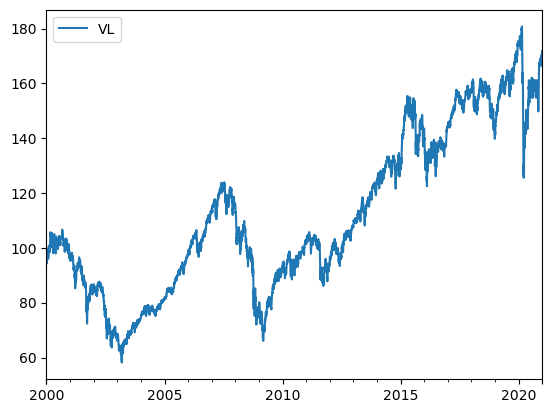

In [7]:
c = VL(sxxr,eonia,100,0.8,2000,20,2000,True)
c.plot()
#d = get_list_protected(c, 2000, 0.9,0)
#d.plot()

# Exemple - Représentations Graphiques des indices

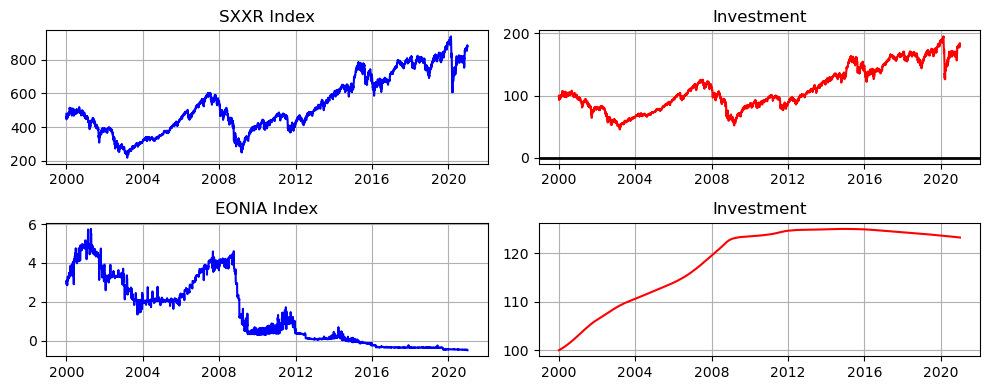

In [8]:
investment = interest(sxxr,100,2001,20,2000)
monnaie = monetarize(eonia, 100, 2001, 20,2000)

# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr["2000":"2020"], c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(investment["2000":"2020"],c="r")
ax2.set_title('Investment')
ax2.grid(True)

# Tracé des graphiques à gauche
ax3.plot(eonia["2000":"2020"], c="b")
ax3.set_title('EONIA Index')
ax3.grid(True)

ax4.plot(monnaie["2000":"2020"],c="r")
ax4.set_title('Investment')
ax4.grid(True)



# Affichage de la figure
plt.tight_layout()
plt.show()


In [9]:
a = particularyear(investment, 2018)
a

,SXXR Index
2017-12-29,164.946359
2018-01-01,164.946359
2018-01-02,164.595024
2018-01-03,165.386726
2018-01-04,166.857014
...,...
2018-12-25,146.100523
2018-12-26,146.100523
2018-12-27,143.669411
2018-12-28,146.572969


## CPPI - Un test sur les planchers, sans protection

In [10]:
class CPPI:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
        
    def liquidative(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):
        df1 = self.df1
        df2 = self.df2
        vl = VL(df1,df2,initial, weight, year, horizon, y0, alldata)
        protec = get_list_protected(vl, year, plancher, horizon)
        
        return protec
    
    def unified(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):

        # Year Y
        df_0 = self.liquidative(initial, weight, plancher, year,horizon, y0,False)
        df_0 = df_0.drop(df_0.index[-1])
        # Year Y+1
        df_1 = self.liquidative(initial, weight, plancher, year+1,horizon, y0,False)
        df_1 = df_1.drop(df_1.index[-1])
        # Year Y+2
        df_2 = self.liquidative(initial, weight, plancher, year+2,horizon, y0,False)
        df_2 = df_2.drop(df_2.index[-1])
        # Year Y+3
        df_3 = self.liquidative(initial, weight, plancher, year+3,horizon, y0,False)
        df_3 = df_3.drop(df_3.index[-1])
        # Year Y+4 (Final)
        df_4 = self.liquidative(initial, weight, plancher, year+4,horizon, y0,False)
        
        # Concat :
        df = pd.concat([df_0,df_1,df_2,df_3,df_4],axis=0)
        return df

<AxesSubplot:>

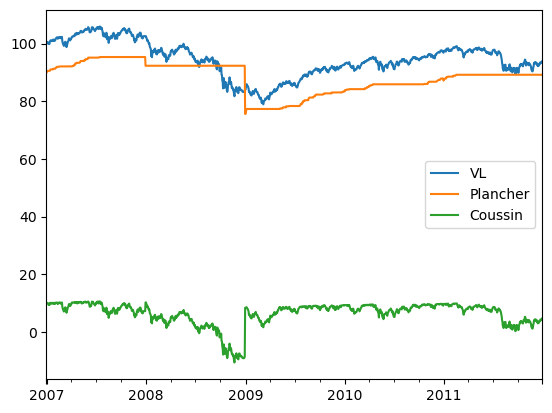

In [26]:
a = CPPI()
b = a.liquidative(100,0.45,0.9,2007,5,2007,False)
c = a.unified(100,0.45,0.9,2007,5,2007,False)
c.plot()

In [27]:
85/100 - 1

-0.15000000000000002

In [12]:
c

,VL,Plancher,Coussin
1999-12-31,100.000000,90.000000,10.000000
2000-01-03,99.627600,90.000000,9.627600
2000-01-04,96.470056,90.000000,6.470056
2000-01-05,94.583874,90.000000,4.583874
2000-01-06,94.261456,90.000000,4.261456
...,...,...,...
2004-12-27,81.188131,73.158444,8.029688
2004-12-28,81.247284,73.158444,8.088840
2004-12-29,81.240052,73.158444,8.081609
2004-12-30,81.240288,73.158444,8.081845


# CPPI - Avec protection

In [13]:
def reajust_date(df:pd.DataFrame)->str:
    tab = df
    n = len(tab)
    coussin = pd.DataFrame(tab["Coussin"])
    coussin["Rang"] = range(n)
    couss = [round(x,4) for x in coussin["Coussin"]]
    
    negcouss = []
    date = []
    count = 0
    if min(couss) <= 0:
        for c in coussin["Coussin"]:
            if c <= 0:
                negcouss.append(count)
                dateJ = coussin.iloc[count:count+1].index[0]
                date.append(dateJ)
            count += 1
    else:
        count = len(coussin)-1
        negcouss.append(count) #The last index
        dateJ = coussin.iloc[count:count+1].index[0]
        date.append(dateJ)
        
    location_index = negcouss[0]
    location_date = date[0]
    
    return location_date, location_index

investment = interest(sxxr,100,2001,20,2000)
monnaie = monetarize(eonia, 100, 2001, 20,2000)

def reajust(df:pd.DataFrame, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia, year:int=2000, y0:int=2000, horizon:int=5,initial:float =100, weight:float = 0.8,alldata:bool=True):
    tab = df
    risk_invest = initial * weight
    norisk_invest = initial * (1-weight)
    investment = interest(df1,risk_invest,year,horizon,y0,alldata)
    monnaie = monetarize(df2, norisk_invest,year,horizon,y0,alldata)
    indexes = concat(investment,monnaie)
    tabulate = concat(tab, indexes)
    date_couss_negative = reajust_date(df)[0]
    data= pd.DataFrame(tabulate.loc[date_couss_negative:str(year)])
    eonia = df2.loc[date_couss_negative:str(year)]
    allocation = data[["SXXR Index", "EONIA Index"]]
    allocation["EONIA"] = eonia
    allocation["EONIA Index"] = allocation["SXXR Index"] + allocation["EONIA Index"]
    allocation["SXXR Index"] = 0
    rate = [x for x in allocation["EONIA"]]
    val = []
    nb = len(allocation)
    count = 0
    index_couss_negative = reajust_date(df)[1]
    if index_couss_negative != len(df)-1:
        for r in rate:
            if count == 0:
                value = allocation.iloc[count,1]
            else:
                value = val[count-1] * (1+r/(365*100))
            count += 1 
            val.append(value)
        allocation['VL'] = val
        before = pd.DataFrame(tabulate["VL"].iloc[0:index_couss_negative,])
        after = pd.DataFrame(allocation["VL"])
        result = pd.concat([before,after],axis=0)
    else:
        result = pd.DataFrame(tabulate["VL"])
    return result



In [14]:
liste = []
# Y
a = VL(sxxr,eonia,initial = 100,weight = 0.85, year = 2007,horizon = 10, y0 = 2007, alldata = False)
b = get_list_protected(a,year = 2007,plancher = 0.9, horizon = 0)
c =  reajust(b, sxxr, eonia, year = 2007, y0 = 2007, horizon = 10,initial = 100, weight = 0.85, alldata = False)
d = get_list_protected(c, year = 2007, plancher=0.9, horizon = 0)
lastval0 = d.iloc[-1,0]

# Y+1
e = VL(sxxr,eonia,initial = lastval0,weight = 0.85, year = 2008,horizon = 10, y0 = 2008, alldata = False)
f = get_list_protected(e,year = 2008,plancher = 0.9, horizon = 0)
g =  reajust(f, sxxr, eonia, year = 2008, y0 = 2008, horizon = 10,initial = lastval0, weight = 0.85, alldata = False)
h = get_list_protected(g, year = 2008, plancher=0.9, horizon = 0)
lastval1 = h.iloc[-1,0]

# Y+2
i = VL(sxxr,eonia,initial = lastval1,weight = 0.85, year = 2009,horizon = 10, y0 = 2009, alldata = False)
j = get_list_protected(i,year = 2009,plancher = 0.9, horizon = 0)
k =  reajust(j, sxxr, eonia, year = 2009, y0 = 2009, horizon = 10,initial = lastval1, weight = 0.85, alldata = False)
l = get_list_protected(k, year = 2009, plancher=0.9, horizon = 0)
lastval2 = l.iloc[-1,0]

df = pd.concat([d,h,l],axis=0)
df["2008-12-25":"2009-01-05"]

,VL,Plancher,Coussin
2008-12-25,88.356362,89.044476,-0.688114
2008-12-26,88.361748,89.044476,-0.682728
2008-12-29,88.367156,89.044476,-0.677320
2008-12-30,88.372640,89.044476,-0.671836
2008-12-31,88.378334,89.044476,-0.666141
2008-12-31,88.378584,79.540726,8.837858
2009-01-01,88.379584,79.541626,8.837958
2009-01-02,90.703846,81.633461,9.070385
2009-01-05,92.307200,83.076480,9.230720


In [20]:
class FinalCPPI:
    def __init__(self, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia):
        self.df1 = df1
        self.df2 = df2

    def finalprotection(self,initial = 100, weight=0.8, year=2000, horizon=5,y0=2000, alldata=False,plancher=0.9,h=5):
        df1 = self.df1
        df2 = self.df2
        
        liste = []
        lastval = initial
        for i in range(h):
            val = VL(df1,df2,lastval,weight,year+i,horizon,y0+i,alldata)
            protect_priori = get_list_protected(val, year+i,plancher,0)
            ajustement = reajust(protect_priori,df1,df2,year+i,y0+i,horizon,lastval,weight,alldata)
            protect_posteriori = get_list_protected(ajustement, year+i, plancher, 0)
            if i != max(range(5)):
                protect_posteriori = protect_posteriori.drop(protect_posteriori.index[-1])
            lastval = protect_posteriori.iloc[-1,0]
            liste.append(protect_posteriori)
        
        df = pd.concat(liste,axis=0)
        return df
        

<AxesSubplot:>

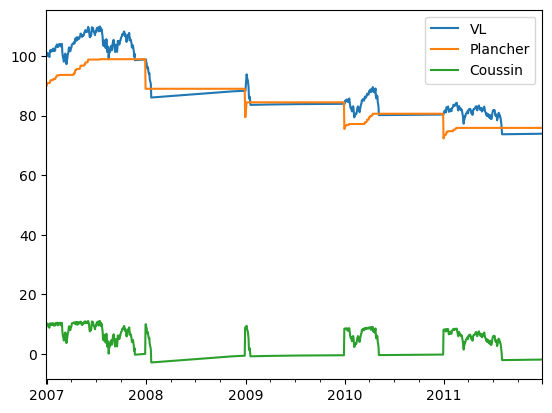

In [21]:
a = FinalCPPI()
b = a.finalprotection(100,0.85,2007,10,2007,False,0.9,5)
b.plot()

<AxesSubplot:>

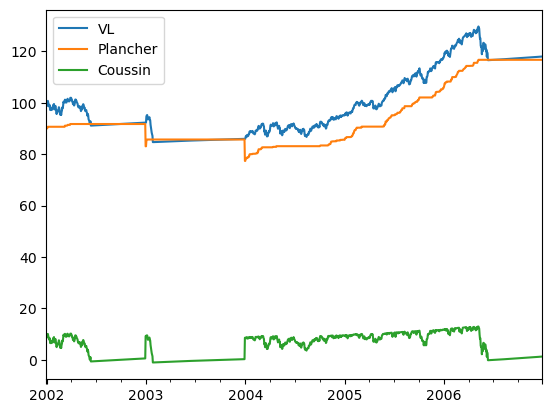

In [22]:
a = FinalCPPI()
b = a.finalprotection(100,0.85,2002,10,2002,False,0.9,5)
b.plot()

<AxesSubplot:>

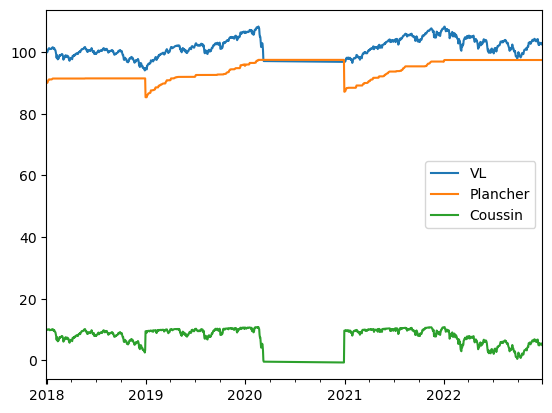

In [24]:
a = FinalCPPI()
b = a.finalprotection(100,0.45,2018,10,2018,False,0.9,5)
b.plot()